In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [ ]:
sdir = '/content/drive/MyDrive/XrayKneeOsteoarthritis'
image_size = (224, 224)
batch_size = 16
k_folds = 5

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
1  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
2  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
3  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
4  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
labels
0    3798
2    2545
4    1790
1    1749
3    1281
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['labels'], random_state=42)

print(train_df['labels'].value_counts())
print(test_df['labels'].value_counts())

labels
0    3418
2    2290
4    1611
1    1574
3    1153
Name: count, dtype: int64
labels
0    380
2    255
4    179
1    175
3    128
Name: count, dtype: int64


In [ ]:
datagen = ImageDataGenerator(
  rescale=1.0/255,
  horizontal_flip = True,
  )

valid_generator = ImageDataGenerator(
    rescale = 1./255
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

test_gen = test_generator.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=image_size,
    batch_size=batch_size, class_mode='categorical', shuffle = True
)

print("Preprocessing dataset selesai.")

Found 1117 validated image filenames belonging to 5 classes.
Preprocessing dataset selesai.


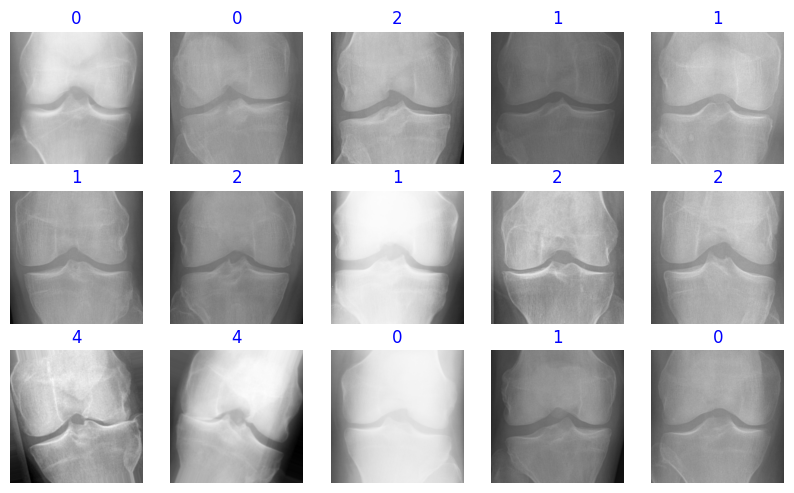

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(10, 10))
    length=len(labels)
    if length<15:   #show maximum of 25 images
        r=length
    else:
        r=15
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(test_gen)

In [ ]:
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

def create_model():
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    x = base_model.output

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 1e-4, weight_decay = 0.001),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

fold_accuracies = []
histories = []
fold = 1

for train_index, val_index in kf.split(train_df, train_df['labels']):
    print(f'\nTraining Fold {fold}...')

    fold_train_df = train_df.iloc[train_index].reset_index(drop = True)
    fold_valid_df = train_df.iloc[val_index].reset_index(drop = True)

    classes = np.unique(fold_train_df['labels'])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_train_df['labels'])
    class_weight_dict = dict(zip(classes, class_weights))
    print(f"Class weights (Fold {fold}):", class_weight_dict)

    train_gen = datagen.flow_from_dataframe(
        fold_train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = valid_generator.flow_from_dataframe(
        fold_valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stopping, reduce_lr]
    )

    histories.append(history)

    scores = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold} - Loss: {scores[0]} - Accuracy: {scores[1]*100:.2f}%")

    fold_accuracies.append(scores[1] * 100)
    fold += 1

print('=================================')
print(f'Average accuracy over {k_folds} folds: {np.mean(fold_accuracies):.2f}% (+/- {np.std(fold_accuracies):.2f})')
print('=================================')



Training Fold 1...
Class weights (Fold 1): {'0': np.float64(0.5878566203365033), '1': np.float64(1.2765687053216839), '2': np.float64(0.877292576419214), '3': np.float64(1.7431670281995661), '4': np.float64(1.2468580294802172)}
Found 8036 validated image filenames belonging to 5 classes.
Found 2010 validated image filenames belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 3171s 6s/step - accuracy: 0.3587 - loss: 1.5119 - val_accuracy: 0.4602 - val_loss: 1.2405 - learning_rate: 1.0000e-04
Epoch 2/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 93s 185ms/step - accuracy: 0.5117 - loss: 1.1298 - val_accuracy: 0.5090 - val_loss: 1.3638 - learning_rate: 1.0000e-04
Epoch 3/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.5890 - loss: 0.9492 - val_accuracy: 0.6139 - val_loss: 0.9096 - learning_rate: 1.0000e-04
Epoch 4/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.6160 - loss: 0.8935 - val_accuracy: 0.6035 - val_loss: 0.9402 - learning_rate: 1.0000e-04
Epoch 5/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.6665 - loss: 0.8267 - val_accuracy: 0.4204 - val_loss: 1.8483 - learning_rate: 1.0000e-04
Epoch 6/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.6852 - loss: 0.7604 - val_accuracy: 0.6816 - val_loss: 0.7694 - learning_rate: 2.0000e-05
Epoch 7/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 95s 188

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


503/503 ━━━━━━━━━━━━━━━━━━━━ 117s 217ms/step - accuracy: 0.3395 - loss: 1.5579 - val_accuracy: 0.4037 - val_loss: 1.2186 - learning_rate: 1.0000e-04
Epoch 2/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 123s 188ms/step - accuracy: 0.5137 - loss: 1.1149 - val_accuracy: 0.6098 - val_loss: 0.9171 - learning_rate: 1.0000e-04
Epoch 3/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.5971 - loss: 0.9491 - val_accuracy: 0.6013 - val_loss: 0.9150 - learning_rate: 1.0000e-04
Epoch 4/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 102s 202ms/step - accuracy: 0.6206 - loss: 0.9049 - val_accuracy: 0.4988 - val_loss: 1.1509 - learning_rate: 1.0000e-04
Epoch 5/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 102s 202ms/step - accuracy: 0.6620 - loss: 0.8182 - val_accuracy: 0.5844 - val_loss: 0.9509 - learning_rate: 1.0000e-04
Epoch 6/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.6913 - loss: 0.7380 - val_accuracy: 0.6899 - val_loss: 0.7365 - learning_rate: 2.0000e-05
Epoch 7/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


503/503 ━━━━━━━━━━━━━━━━━━━━ 107s 198ms/step - accuracy: 0.3630 - loss: 1.5071 - val_accuracy: 0.4246 - val_loss: 1.6228 - learning_rate: 1.0000e-04
Epoch 2/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 102s 203ms/step - accuracy: 0.5216 - loss: 1.1063 - val_accuracy: 0.5879 - val_loss: 1.0113 - learning_rate: 1.0000e-04
Epoch 3/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 143s 205ms/step - accuracy: 0.5916 - loss: 0.9640 - val_accuracy: 0.4619 - val_loss: 2.4686 - learning_rate: 1.0000e-04
Epoch 4/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - accuracy: 0.6255 - loss: 0.8920 - val_accuracy: 0.6048 - val_loss: 0.9309 - learning_rate: 1.0000e-04
Epoch 5/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - accuracy: 0.6537 - loss: 0.8295 - val_accuracy: 0.3524 - val_loss: 1.8462 - learning_rate: 1.0000e-04
Epoch 6/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - accuracy: 0.6678 - loss: 0.8020 - val_accuracy: 0.6297 - val_loss: 0.9607 - learning_rate: 1.0000e-04
Epoch 7/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


503/503 ━━━━━━━━━━━━━━━━━━━━ 106s 196ms/step - accuracy: 0.3358 - loss: 1.5722 - val_accuracy: 0.3454 - val_loss: 1.5295 - learning_rate: 1.0000e-04
Epoch 2/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.5150 - loss: 1.1408 - val_accuracy: 0.5645 - val_loss: 1.0123 - learning_rate: 1.0000e-04
Epoch 3/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.5531 - loss: 1.0268 - val_accuracy: 0.5386 - val_loss: 1.1554 - learning_rate: 1.0000e-04
Epoch 4/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - accuracy: 0.6220 - loss: 0.9132 - val_accuracy: 0.5948 - val_loss: 0.9351 - learning_rate: 1.0000e-04
Epoch 5/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.6359 - loss: 0.8599 - val_accuracy: 0.6297 - val_loss: 0.8602 - learning_rate: 1.0000e-04
Epoch 6/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.6643 - loss: 0.8136 - val_accuracy: 0.6546 - val_loss: 0.7870 - learning_rate: 1.0000e-04
Epoch 7/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 141s 186ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


503/503 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - accuracy: 0.3487 - loss: 1.5327 - val_accuracy: 0.5416 - val_loss: 1.0554 - learning_rate: 1.0000e-04
Epoch 2/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.5051 - loss: 1.1082 - val_accuracy: 0.5824 - val_loss: 0.9736 - learning_rate: 1.0000e-04
Epoch 3/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.5957 - loss: 0.9540 - val_accuracy: 0.5764 - val_loss: 0.9908 - learning_rate: 1.0000e-04
Epoch 4/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 188ms/step - accuracy: 0.6262 - loss: 0.8755 - val_accuracy: 0.5948 - val_loss: 0.9711 - learning_rate: 1.0000e-04
Epoch 5/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 102s 202ms/step - accuracy: 0.6552 - loss: 0.8175 - val_accuracy: 0.6013 - val_loss: 0.9160 - learning_rate: 1.0000e-04
Epoch 6/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.6768 - loss: 0.7852 - val_accuracy: 0.6859 - val_loss: 0.7581 - learning_rate: 1.0000e-04
Epoch 7/20
503/503 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step 

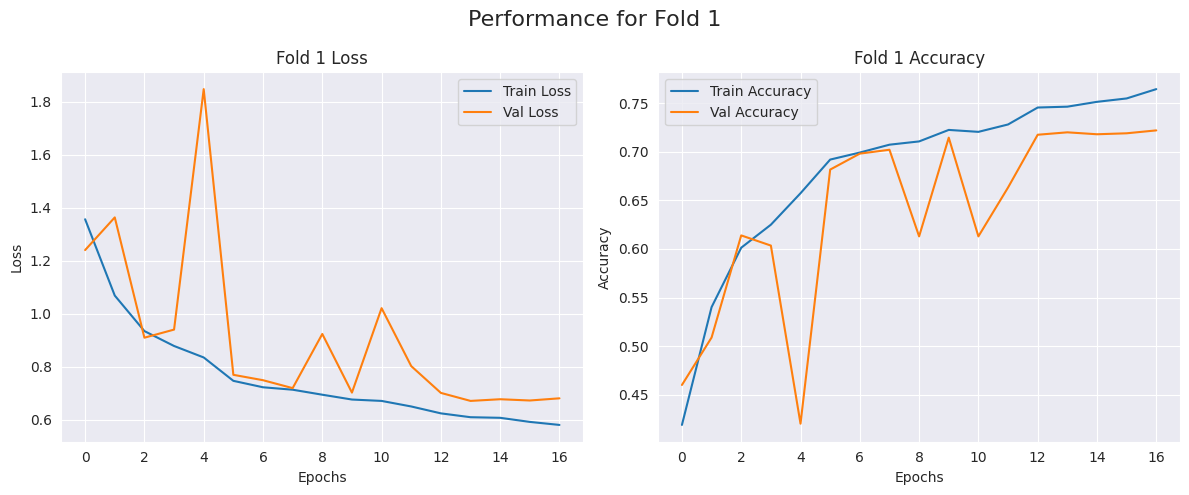

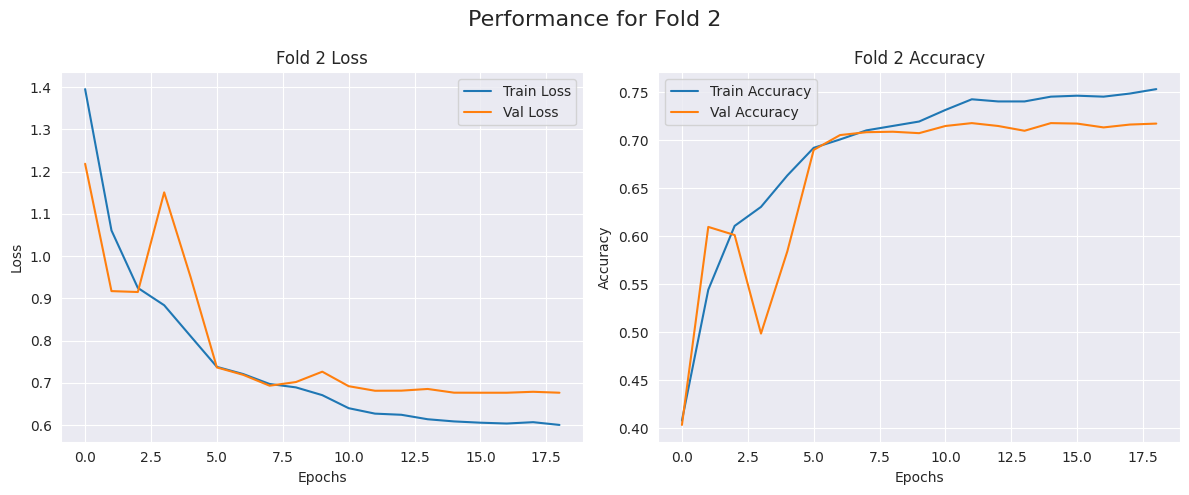

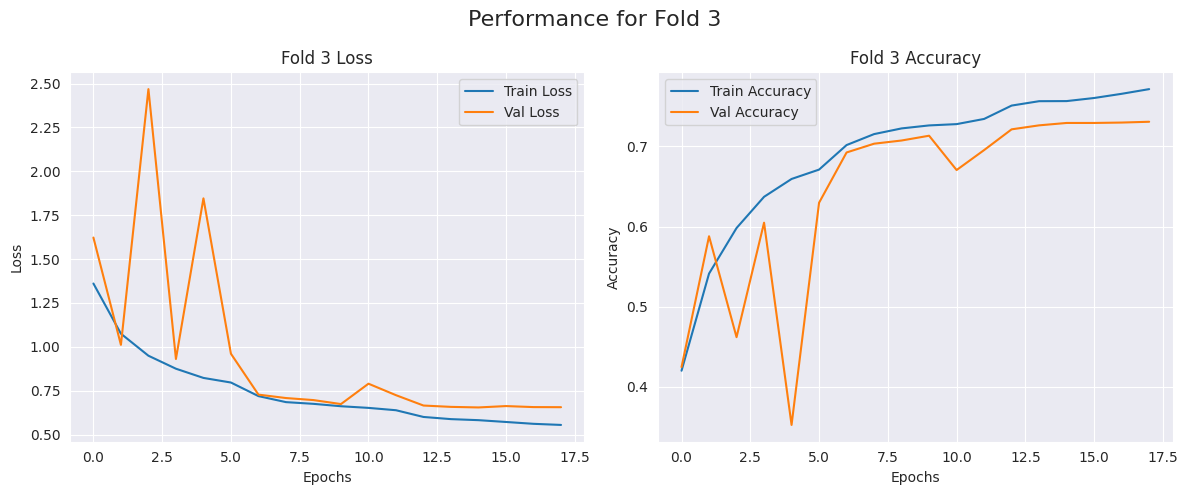

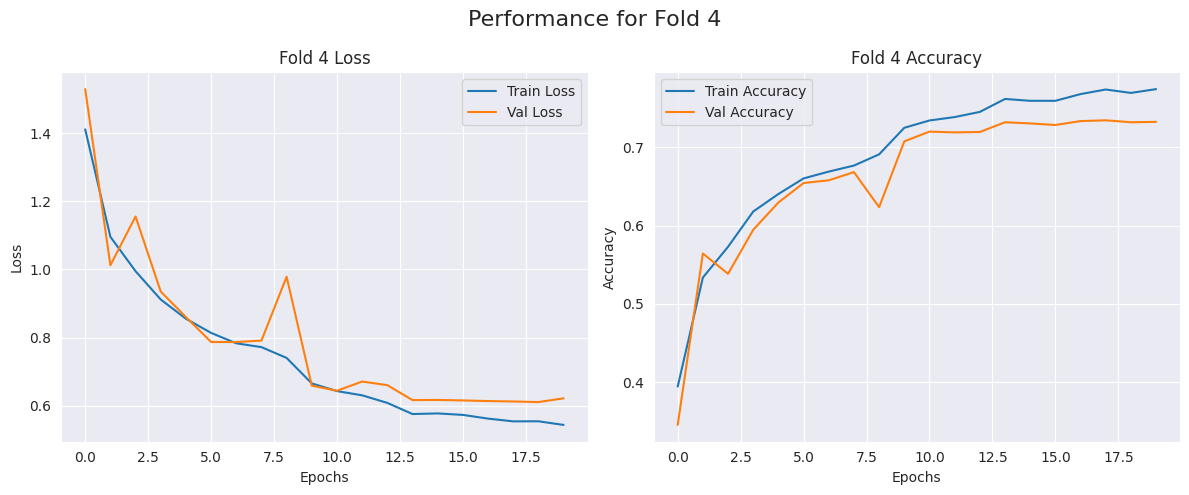

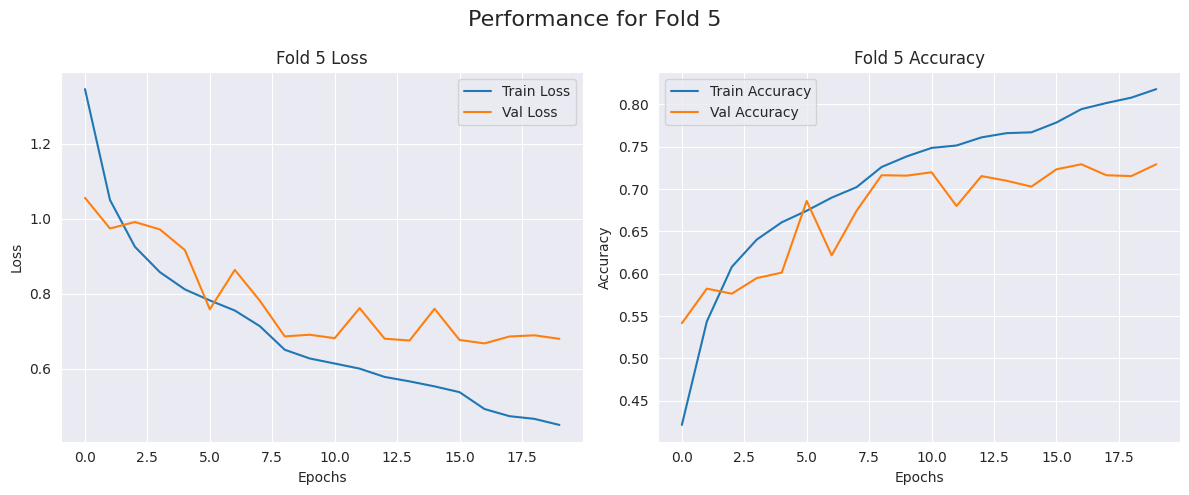

Semua plot selesai!


In [ ]:
for i, history in enumerate(histories, start=1):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Performance for Fold {i}', fontsize=16)
    plt.tight_layout()
    plt.show()  # tampilkan plot fold i

print("Semua plot selesai!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

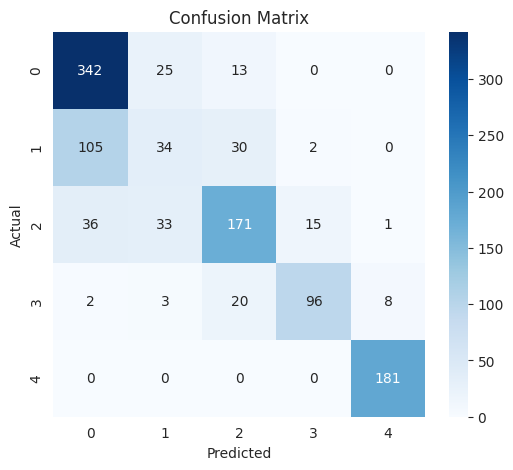

              precision    recall  f1-score   support

           0       0.71      0.90      0.79       380
           1       0.36      0.20      0.26       171
           2       0.73      0.67      0.70       256
           3       0.85      0.74      0.79       129
           4       0.95      1.00      0.98       181

    accuracy                           0.74      1117
   macro avg       0.72      0.70      0.70      1117
weighted avg       0.71      0.74      0.72      1117



In [ ]:
y_true = []
y_pred = []
class_labels = list(test_gen.class_indices.keys())

for _ in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)
    y_true.extend(np.argmax(y_batch, axis=1))  # Label asli
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))  # Prediksi model

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
model.save('/content/drive/MyDrive/my_model_90_10_16.h5')